# Earth quake
> graph laplacian

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

,Date,Latitude,Longitude,Magnitude
0,01/02/1965,19.2460,145.6160,6.0
1,01/04/1965,1.8630,127.3520,5.8
2,01/05/1965,-20.5790,-173.9720,6.2
3,01/08/1965,-59.0760,-23.5570,5.8
4,01/09/1965,11.9380,126.4270,5.8
...,...,...,...,...
23407,12/28/2016,38.3917,-118.8941,5.6
23408,12/28/2016,38.3777,-118.8957,5.5
23409,12/28/2016,36.9179,140.4262,5.9
23410,12/29/2016,-9.0283,118.6639,6.3


In [3]:
# df.assign 임시 데이터 만들어줘서 원래 데이터 안 건들이게
lst=[df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2017-1965)]

pipe는 튜플로 묶여 있어서 [][] 해줘야 데이터프레임으로 나오지

한 번에 list로 안 되어서 numpy 해준 후 list

`-` 숙제: 

지진자료에서 1985년 이후의 자료만 고른뒤에 HeatMapWithTime()을 이용하여 시각화하라.

In [4]:
lst2=[df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1985"').\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-1985)]

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

In [13]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2015"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/02/2015,6.5739,60.3653,5.5,2015
1,01/05/2015,-43.0546,171.2364,5.6,2015
2,01/06/2015,55.2049,163.2446,5.6,2015
3,01/07/2015,5.9045,-82.6576,6.5,2015
4,01/08/2015,-61.6118,161.3346,5.7,2015
...,...,...,...,...,...
910,12/28/2016,38.3917,-118.8941,5.6,2016
911,12/28/2016,38.3777,-118.8957,5.5,2016
912,12/28/2016,36.9179,140.4262,5.9,2016
913,12/29/2016,-9.0283,118.6639,6.3,2016


In [14]:
f = _df.loc[:,"Magnitude"].iloc[:-1,]  # 일단 마지막 꺼 수 안맞으니까...일단...

In [15]:
f.shape

(914,)

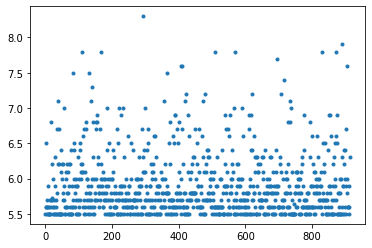

In [16]:
plt.plot(f,'.')

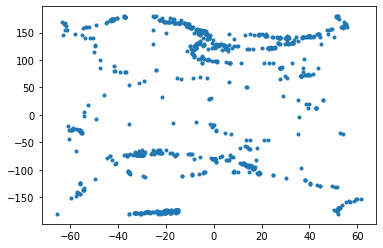

In [17]:
plt.plot( _df.Latitude,_df.Longitude,'.')

$$dist((x_i,y_i),(x_j,y_j))$$

In [18]:
def dist(i,j):
    return np.sqrt( ( ( _df.Latitude[i] - _df.Latitude[i-1] )**2) + ( ( _df.Longitude[j] - _df.Longitude[j-1] )**2) )

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [19]:
def weight(i,j,theta=100,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [ ]:
W = np.array([[weight(i,j) for i in range(1,len(_df))] for j in range(1,len(_df))])

In [ ]:
W

In [ ]:
D = np.diag(W.sum(axis=1))

In [ ]:
D

In [ ]:
L = D - W

In [ ]:
L

고유값 분해

In [ ]:
λ, Ψ = np.linalg.eig(L)

In [ ]:
Λ = np.diag(λ)

In [ ]:
fig,ax =plt.subplots(10,10)
k=0
for i in range(10):
    for j in range(10):
        ax[i][j].plot(f @ np.outer(Ψ[:,k], Ψ[:,k]))
        ax[i][j].set_ylim([-20,20])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(20)            
fig.set_figheight(20)
fig.tight_layout()        

In [ ]:
fig,ax =plt.subplots(10,10)
k=500
for i in range(10):
    for j in range(10):
        ax[i][j].plot(f @ np.outer(Ψ[:,k], Ψ[:,k]))
        ax[i][j].set_ylim([-20,20])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(20)            
fig.set_figheight(20)
fig.tight_layout()        